# Entropy Image Analytics
The purpose of this notebook is to design and evaluate functions which calculate entropy in an image. This is accomplished via comparing the input image to a randomly generated image, i.e. to an image of maximum entropy.

## Libraries
Uses the torchvision dataset for MNIST.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from numpy import random as rnd
import warnings,os,sys,time,datetime

import torch

import torchvision
from torch import nn
from torch.nn import functional as F

import pandas as pd

from sklearn.cluster import KMeans

from scipy import ndimage,signal

## Pipeline function Implementation
One-off functions needed to quickly get a first impression of how different entropy analysis techniques will evaluate.

In [2]:
def binarize_image(xx,verbose=False):
    o_shape = xx.shape
    xout = KMeans(n_clusters=2).fit_predict(xx.flatten().reshape(-1,1)).reshape(o_shape)
    if verbose:
        plt.imshow(xout)
        plt.show()
    return xout

In [3]:
def preprocessing_pipeline_images(X0):
    # Resize images to scale 0.5
    #X0 = ndimage.zoom(X0,[1,0.5,0.5])
    # Binarize image
    X0 = binarize_image(X0)
    
    # Return preprocessed images
    return X0

In [4]:
def plot_imgs_with_entropy(X0,entropy_fun):
    
    # Setup
    fig,ax = plt.subplots(nrows=1,ncols=4,figsize=(15,5))
    c_idx = rnd.permutation(X0.shape[0])[0]

    # Make random image of same size
    img0 = rnd.randint(2,size=X0[0].shape)
    entr0 = entropy_fun(img0)
    ax[0].imshow(img0)
    ax[0].set_title('Entr = {0:.2f}'.format(entr0))
    
    # Make half-random image
    img1 = np.concatenate([rnd.randint(2,size=(X0[0].shape[0],14)),np.zeros(shape=(X0[0].shape[0],14))],axis=1)
    entr1 = entropy_fun(img1)
    ax[1].imshow(img1)
    ax[1].set_title('Entr = {0:.2f}'.format(entr1))
    
    # Make image with constrained degree of randomness by permutation of sample image
    img2 = rnd.permutation(X0[c_idx])
    entr2 = entropy_fun(img2)
    ax[2].imshow(img2)
    ax[2].set_title('Entr = {0:.2f}'.format(entr2))
    
    # Select arbitrary image from sample collection
    img3 = X0[c_idx]
    entr3 = entropy_fun(img3)
    ax[3].imshow(img3)
    ax[3].set_title('Entr = {0:.2f}'.format(entr3))

    # Plot final total image
    plt.show()
    return

## Samples Image Load
Using sample images from the MNIST torchvision library. These are very low-entroy images. Any correct implementation of an entropy analytics function will produce different outputs for those images as input, or for random inputs.

In [5]:
# Connect to dataset, should already be downloaded
dataset = torchvision.datasets.MNIST(
    root='./../../../../../../../Dropbox/TF_data/MNIST/',
    download=True,
    train=True,
    transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Normalize((0.1307,), (0.3081,))])
)

# Loader, select desired number of images
train_loader = torch.utils.data.DataLoader(dataset,shuffle=True,batch_size=100)

# Transform into torch array
samples = enumerate(train_loader)
_,(X,y) = next(samples)

# Transform into numpy array
X0 = X.numpy().reshape(X.shape[0],X.shape[2],X.shape[3])
y0 = y.numpy()

# Apply preprocessing pipeline
X0 = preprocessing_pipeline_images(X0)

## Plot Images along with calculated Entropy
Plots four images
* img0 is taken from the sample collection
* img1 is completely random
* img2 is half-random, half-deterministic
* img3 three is a random permutation of img0
In a correct implementation, I would expect 
        entropy(img0) > entropy(img1) > entropy(img2) > entropy(img3)

### Distance-based Entropy Calculation
Calculate the entropy based on the average distance of this image to randomly filled images.

In [6]:
def calc_entropy_distance(arr):
    rnd.seed(0)
    num_iter = 1000
    arr = arr.reshape(-1)
    entr_vec = []
    for k in range(num_iter):
        c_entropy = abs(rnd.permutation(arr) - arr).sum()/arr.shape[0]
        entr_vec.append(c_entropy)
    entropy = sum(entr_vec)/len(entr_vec)
    return entropy

The problem with this approach seems to be that it only accounts for the image pixel count. The differences between images img2 and img3 cannot be recovered.

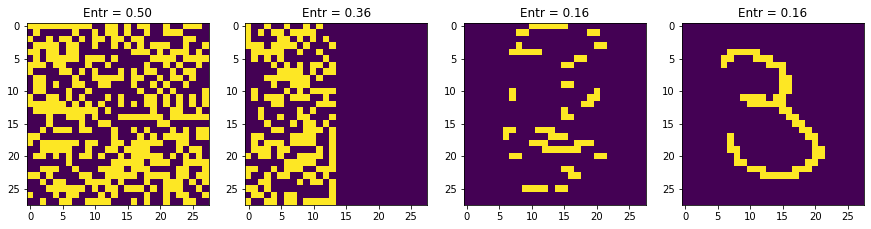

In [7]:
plot_imgs_with_entropy(X0,entropy_fun=calc_entropy_distance)

### Correlation-based approach
This suggests that a better option is to use a correlation-based approach. Scipy implements image correlation, but I will first have to investigate how to break this down to one number.

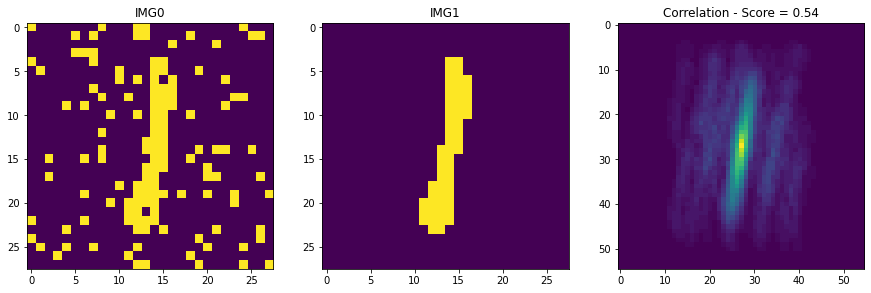

In [72]:
# Select images
img0 = X0[20].copy()#rnd.randint(0,2,X0[0].shape)
img1 = X0[20].copy()#rnd.randint(0,2,X0[0].shape)

mutate_image = True
if mutate_image:
    for k0 in range(10):
        for k1 in range(10):
            c0 = rnd.randint(0,img0.shape[0])
            c1 = rnd.randint(0,img0.shape[0])
            img0[c0,c1] = (img0[c0,c1]+1)%2

# Correlation Score
Z = signal.correlate(img0,img1)

# Create figure to visualize output
fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(15,5))

# Plot images, correlation
ax[0].imshow(img0)
ax[0].set_title('IMG0')
ax[1].imshow(img1)
ax[1].set_title('IMG1')
ax[2].imshow(Z)
ax[2].set_title('Correlation - Score = {0:.3}'.format(np.corrcoef(img0.flatten(),img1.flatten())[0,1]))

# Display image
plt.show()